In [1]:
# !pip install facenet-pytorch

In [2]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from segment_transform import SegmentImage
from facenet_pytorch import MTCNN, InceptionResnetV1
import requests
import io
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
file_id = '1jrhZswFJ1tjc9P4mLY3vuY08rjK66WvT'
file_name = 'archive.zip'
downloaded_file = drive.CreateFile({'id': file_id})
downloaded_file.GetContentFile(file_name)

In [5]:
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(device)

cuda


In [7]:
train_dir = "dataset/archive/archive (7)/train_data"
test_dir = "dataset/archive/archive (7)/test_data"
val_dir = "dataset/archive/archive (7)/validation_data"

In [8]:
from torchvision.transforms import v2
mtcnn = MTCNN(keep_all=True, device=device)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),

    SegmentImage(mtcnn=mtcnn),
    v2.Normalize(mean=mean, std=std),
])


trainset =  torchvision.datasets.ImageFolder(train_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
valset = torchvision.datasets.ImageFolder(val_dir, transform=transform)

In [9]:
batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

classes = ('drowsy', 'notdrowsy')

In [10]:
print(trainset.__len__())

46565


tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0])
torch.Size([32, 3, 299, 299])


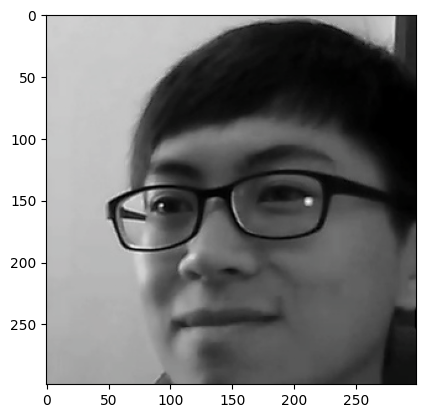

In [11]:
def imshow(img):
    inv_normalize = v2.Normalize(mean=-mean/std, std=1/std)  # Adjust means and stds if different
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


print(labels)
print(images[0].shape)
imshow(images[0][0])


#Define Model, Loss and Optimizer

In [12]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Step 1: Load pre-trained InceptionV3 model
inception = models.inception_v3(pretrained=True)


num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(num_ftrs, 2)

# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = nn.Linear(num_ftrs, 2)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(inception.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 99.7MB/s]


In [13]:
def train_model(models, mode, dataset, num_epochs, optimizer, exp_lr_scheduler, criterion, batch_size=4):
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  if mode == "ensemble":
    model_eye = models[0].to(device)
    model_mouth = models[1].to(device)
    model = model[2].to(device)
    model.train()
  else:
    model = models[0].to(device)
    model.train()

  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(dataloader, 0):
        if mode == "ensemble":
          inputs_eye, labels = data[0][0].to(device), data[1].to(device)
          inputs_mouth, _ = data[0][1].to(device), data[1].to(device)
          outputs_eye, aux_outputs = model_eye(inputs_eye)
          outputs_mouth, aux_outputs_mouth = model_mouth(inputs_mouth)
          outputs_eye = torch.where(outputs_eye > 0.5, torch.ones_like(outputs_eye), torch.zeros_like(outputs_eye))
          outputs_mouth = torch.where(outputs_mouth > 0.5, torch.ones_like(outputs_mouth), torch.zeros_like(outputs_mouth))
          outputs_eye_and_mouth = torch.add(outputs_eye, outputs_mouth)
          outputs = model(outputs_eye_and_mouth)
          loss = criterion(outputs, labels)
        else:
          if mode == "eye":
             inputs, labels = data[0][0].to(device), data[1].to(device)
          elif mode == "mouth":
             inputs, labels = data[0][1].to(device), data[1].to(device)
          else:
             raise ValueError("Mode must be eye mouth or ensemble.")
          optimizer.zero_grad()
          outputs, aux_outputs = inception(inputs)
          loss1 = criterion(outputs, labels)
          loss2 = criterion(aux_outputs, labels)
          loss = loss1 + 0.4*loss2

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 49:.3f}')
            running_loss = 0.0

    epoch_loss = running_loss / len(trainset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    exp_lr_scheduler.step()

    torch.save(model.state_dict(), 'inception_eye_model_weights_after_one_epoch.pth')

  print('Finished Training')

In [14]:
models = [inception]
train_model(models,"eye",trainset,1,optimizer,exp_lr_scheduler,criterion,batch_size=32)

[1,    50] loss: 0.867
[1,   100] loss: 0.578
[1,   150] loss: 0.423
[1,   200] loss: 0.352
[1,   250] loss: 0.335
[1,   300] loss: 0.291
[1,   350] loss: 0.257
[1,   400] loss: 0.244
[1,   450] loss: 0.225
[1,   500] loss: 0.221
[1,   550] loss: 0.202
[1,   600] loss: 0.179
[1,   650] loss: 0.192
[1,   700] loss: 0.172
[1,   750] loss: 0.147
[1,   800] loss: 0.185
[1,   850] loss: 0.131
[1,   900] loss: 0.204
[1,   950] loss: 0.145
[1,  1000] loss: 0.166
[1,  1050] loss: 0.173
[1,  1100] loss: 0.140
[1,  1150] loss: 0.176
[1,  1200] loss: 0.131
[1,  1250] loss: 0.127
[1,  1300] loss: 0.145
[1,  1350] loss: 0.148
[1,  1400] loss: 0.133
[1,  1450] loss: 0.100
Epoch [1/1], Loss: 0.0000
Finished Training


In [15]:
from google.colab import files
files.download('inception_eye_model_weights_after_one_epoch.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>